# Assumption

Suppose we visit a wild animal preserve where we know that the only animals are lions and tigers and bears, but we don't know how many of each there are. During the tour, we see 3 lions, 2 tigers, and 1 bear. **Assuming that every animal had an equal chance to appear in our sample, estimate the prevalence of each species. What is the probability that the next animal we see is a bear?**

The overall system is as follows:

- The underlying model is a multinomial distribution with parameters $p_k$
- The prior distribution of $p_k$ is a Dirichlet Distribution (The prior for a multinomial distribution in Bayesian statistics is a Dirichlet distribution)
- The $\alpha$ vector is a parameter of the prior Dirichlet Distribution, hence a hyperparameter

In [11]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
# Linear Regression to verify implementation
from sklearn.linear_model import LinearRegression
# Scipy for statistics
import scipy
# PyMC3 for Bayesian Inference
import pymc3 as pm

In [8]:
# observations
animals = ['lions', 'tigers', 'bears']
c = np.array([3, 2, 1])
# hyperparameters (as every animal had an equal chance to appear)
alphas = np.array([1, 1, 1])

## Frequentist Expected Value

One way to get a single point estimate of the prevalence is to use the expected value of the posterior for $p_k$. The expected value of a Dirichlet-Multinomial Distribution is:

$${\displaystyle \operatorname {E} [p_{i}\mid \mathbb {X} ,{\boldsymbol {\alpha }}]={\frac {c_{i}+\alpha _{i}}{N+\sum _{k}\alpha _{k}}}}$$
Using $\alpha = [1, 1, 1]$, and the observation vector $c = [3, 2, 1]$ we get the expected prevalances:

$$p_{lions} = \frac{4}{9} = 44.4\%$$$$p_{tigers} = \frac{3}{9} = 33.3\%$$$$p_{bears} = \frac{2}{9} = 22.2\%$$


Given the relatively few observations, there should be a large amount of uncertainty; to capture that, we turn to Bayesian Modeling.


## Bayesian Modeling
we are using a multinomial as our model, a Dirichlet distribution as the prior, and a specified hyperparameter vector. The objective is to find the parameters of the multinomial, $p_k$ which are the probability of each species given the evidence.

### PyMC3 and MCMC
To solve the problem, we'll build a model in PyMC3 and then use a variant of Monte Carlo to draw samples from the posterior. With enough samples, the estimate will converge on the true posterior. Along with single point estimates (such as the mean of sampled values), MCMC also gives us built in uncertainty because we get thousands of possible values from the posterior.

For building a model in PyMC3, each distribution is specified, along with the required parameters. We assign the observed counts to the observed parameter of the multinomial which in turn has the Dirichlet as the prior.

For the assumption, every animal had an equal chance to appear in our sample, we'll use $\alpha = [1, 1, 1]$ for our main model.

In [9]:
with pm.Model() as model:
    # Parameters of the Multinomial are from a Dirichlet
    parameters = pm.Dirichlet('parameters', a=alphas, shape=3)
    # Observed data is from a Multinomial distribution
    observed_data = pm.Multinomial(
        'observed_data', n=6, p=parameters, shape=3, observed=c)

In [10]:
model

### Sampling from the Model

The cell below samples 1000 draws from the posterior in 2 chains. We use 500 samples for tuning which are discarded. This means that for each random variable in the model - the parameters - we will have 2000 values drawn from the posterior distribution.

In [12]:
with model:
    # Sample from the posterior
    trace = pm.sample(draws=1000, chains=2, tune=500, 
                      discard_tuned_samples=True)

/Users/sharonwu/opt/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.


### Inspecting Results

PyMC3 offers comprehensive tools for inspecting the results of a trace. We can start by getting the stats in a dataframe.

In [13]:
summary = pm.summary(trace)
summary.index = animals
summary

/Users/sharonwu/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lions,0.441,0.161,0.154,0.734,0.004,0.003,1439.0,1439.0,1402.0,1025.0,1.0
tigers,0.340,0.156,0.084,0.635,0.004,0.003,1354.0,1323.0,1286.0,1115.0,1.0
bears,0.219,0.130,0.011,0.446,0.003,0.002,1614.0,1513.0,1515.0,1045.0,1.0


For the table above, the mean for a bear to appear is very close to the expected value we got, 22.2%. However, instead of just getting one number, we get a range of uncertainty as indicated by the large standard deviation and 95% highest probability interval.

In [17]:
#Samples
trace_df = pd.DataFrame(trace['parameters'], columns = animals)
trace_df.head()

,lions,tigers,bears
0,0.676275,0.256239,0.067487
1,0.395457,0.452786,0.151758
2,0.408697,0.212307,0.378996
3,0.507043,0.060966,0.431992
4,0.562050,0.225044,0.212906


In [19]:
# For probabilities use samples mean
pvals = trace_df.iloc[:, :3].mean(axis = 0)
pvals

lions     0.440897
tigers    0.340240
bears     0.218863
dtype: float64

### Diagnostic Plots

PyMC3 offers a number of plotting options for inspecting our samples.

#### Posterior Plot

/Users/sharonwu/opt/anaconda3/lib/python3.8/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn(
/Users/sharonwu/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


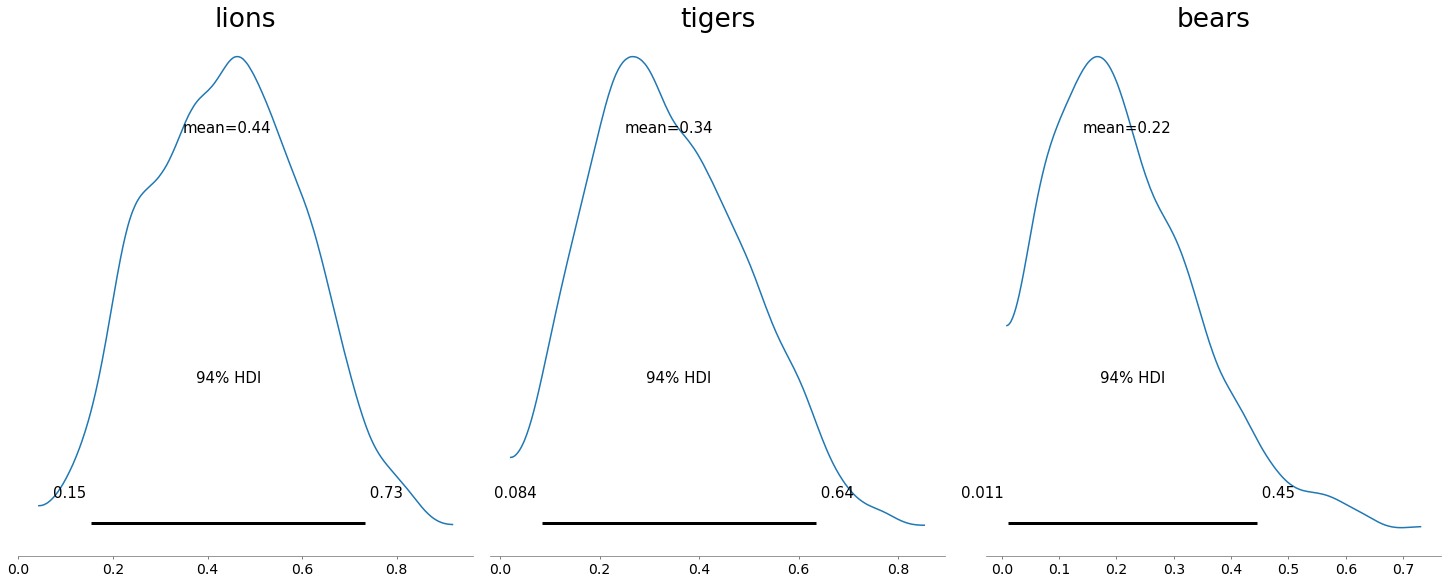

In [24]:
ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 8));

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);

The 95% HPD is the same idea as a 95% confidence interval in frequentist statistics. In Bayesian stats, this is called the Highest Posterior Density.

#### Traceplot
The traceplot shows a kernel density estimate (a smoothed histogram) on the left and all the samples that were drawn on the right. We collapse the chains on th plots (combined = True) but in reality we drew 2 independent chains.

/Users/sharonwu/opt/anaconda3/lib/python3.8/site-packages/pymc3/plots/__init__.py:35: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn(
/Users/sharonwu/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


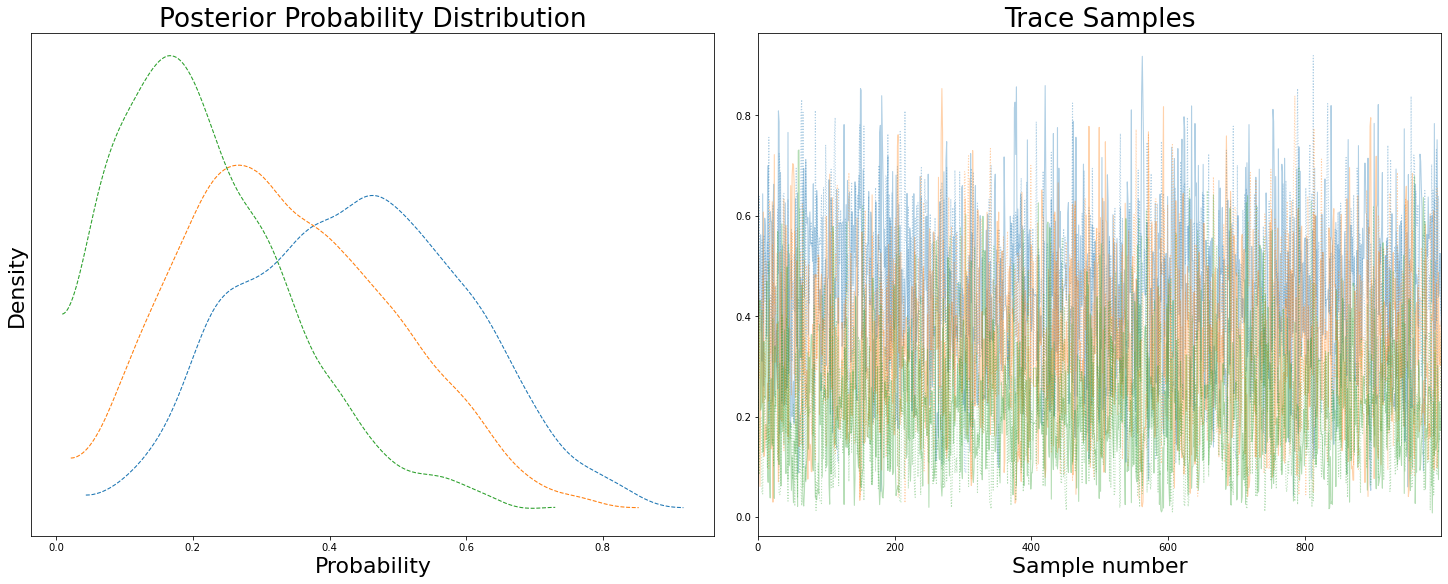

In [26]:
prop_cycle = plt.rcParams['axes.prop_cycle']
cs = [x['color'] for x in list(prop_cycle)]

ax = pm.traceplot(trace, varnames = ['parameters'], figsize = (20, 8), combined = True);
ax[0][0].set_title('Posterior Probability Distribution'); ax[0][1].set_title('Trace Samples');
ax[0][0].set_xlabel('Probability'); ax[0][0].set_ylabel('Density');
ax[0][1].set_xlabel('Sample number');

The best parts about Bayesian Inference are the incorporation of priors and the uncertainty inherent in the methods. With the scant evidence, we can provide estimates, but only with a large amount of uncertainty. More visits to the wildlife preserve would certainly help to clear up the matter!